<a href="https://colab.research.google.com/github/juan-villa02/medical_vqa_vlm/blob/main/code/notebooks/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VQA Model - BERT + ResNet18

## Libraries/Dependencies

In [74]:
# # Install dependencies for local running
# !pip install torch
# !pip install torchvision
# !pip install PIL
# !pip install skimage
# !pip install scipy
# !pip install transformers
# !pip install bertviz
# !pip install seaborn
# !pip install matplotlib
# !pip install numpy
# !pip install tqdm
# !pip install zipfile

In [75]:
# PyTorch framework
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as utils
# Image and mask handling
from PIL import Image
from skimage import transform
import scipy.io as sio
# Transformers (Hugginface)
from transformers import AutoTokenizer, BertForQuestionAnswering, VisualBertModel, VisualBertForQuestionAnswering, VisualBertConfig
# Attention visualization
#from bertviz import head_view
import seaborn as sns
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Extra dependencies
import json
import os
from tqdm import tqdm
import zipfile
from google.colab import files

In [76]:
# Set training device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Paths & Data Extraction

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
path_dir = '.'
path_dir = '/content/drive/MyDrive/TFG Juan Villanueva/databases_qa.zip'

In [79]:
# Data folder
data_folder = './data/'

In [80]:
# ISIC_2016 database
train_ISIC_path = 'databases_qa/ISIC_2016'

In [81]:
# def filter_json(json_file, images_dir, output_file):
#    filtered_data = []

#    with open(json_file, 'r') as f:
#        data = json.load(f)

#        for item in data:
#            image_id = item['image_id'] + '.jpg'
#            image_path = os.path.join(images_dir, image_id)

#            # Check if the image file exists
#            if os.path.exists(image_path):
#                filtered_data.append(item)

#    # Write the filtered data to the output JSON file
#    with open(output_file, 'w') as f:
#        json.dump(filtered_data, f, indent=4)

#    return

In [82]:
# json_file = '/content/data/databases_qa/ISIC_2016/qa_ISIC.json'
# images_dir = '/content/data/databases_qa/ISIC_2016/images/ISBI2016_ISIC_Part1_Test_Data_orig'
# output_file = 'qa_filtered_ISIC.json'
# filter_json(json_file, images_dir, output_file)

In [83]:
# ISIC_2016 database (images and masks)
train_extra_ISIC_path = 'ISBI2016_ISIC_Part3_Training_Data_orig'

In [84]:
# Pizarro database (images)
pizarro_path = 'databases_qa/pizarro'

In [85]:
# Function to extract databases from the main zip file
def extract_databases(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [86]:
# Extract all databases from the main zip file
if path_dir != '.':
  extract_databases(path_dir, data_folder)

In [87]:
# ISIC_2016 images
database1_path = os.path.join(data_folder, train_ISIC_path)

In [88]:
# Pizarro images
# 500 imágenes; Las 46 primeras son más complejas, en cuanto a diagnóstico. (Entrega 1) El resto están más equilibradas (Entrega 2-5)
database2_path = os.path.join(data_folder, pizarro_path)

## VQA Dataset - Images, Masks, & QA

In [89]:
# Dataset class to load images and questions
class VQADataset(Dataset):
    def __init__(self, data_dir, json_file, tokenizer=None, transform=None, extraPath=None):
        self.data_dir = data_dir
        self.images_dir = os.path.join(self.data_dir, 'images')
        self.masks_dir = os.path.join(self.data_dir, 'masks')

        # Handle special ISIC data folder
        self.extraPath = extraPath
        if self.extraPath is not None:
            self.images_dir = os.path.join(self.images_dir, self.extraPath)
            self.masks_dir = os.path.join(self.masks_dir, self.extraPath)

        self.transform = transform
        self.tokenizer = tokenizer

        with open(json_file, 'r') as f:
            self.data = json.load(f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        item = self.data[idx]
        image_path = os.path.join(self.images_dir, item['image_id'])

        # Ensure the image ID ends with ".jpg"
        if not image_path.endswith(".jpg"):
            image_path += ".jpg"

        # Check if the image is available
        try:
          image = Image.open(image_path).convert('RGB')

          # Case 1: Pizarro dataset
          if self.extraPath is None:
            mask_id = item['image_id'].split('.')[0]
            mask_name = 'L' + mask_id + '.pgm'
            mask_path = os.path.join(self.masks_dir, mask_name)
            mask = Image.open(mask_path)

          # Case 2: ISIC dataset
          else:
            mask_path = os.path.join(self.masks_dir, item['image_id']) + '_Segmentation.png'
            mask = Image.open(mask_path)

          if self.transform:
              image, mask = self.transform((image, mask))

          # Store questions and answers in two different arrays
          qa_pairs = item['qa_pairs']
          questions = [qa['question'] for qa in qa_pairs]
          answers = [qa['answer'] for qa in qa_pairs]

        except FileNotFoundError as e:

          image = None
          mask = None
          questions = None
          answers = None

        return image, mask, questions, answers

## Load pre-trained ResNet18

In [90]:
# Load ResNet-18 model from .pth file
def load_resnet(path, optimizer=None, scheduler=None):
    resnet = models.resnet18()
    # Remove final fully connected layer and avg pooling (we do not want the model to return labels but features with dimension)
    resnet.fc = nn.Identity()
    resnet.avgpool = nn.Identity()

    # Load the weights
    state_dict = torch.load(path, map_location=device)['state_dict']

    # Remove unexpected keys if they exist
    unexpected_keys = ['fc.weight', 'fc.bias']
    for key in unexpected_keys:
        if key in state_dict:
            del state_dict[key]

    # Load the weights
    resnet.load_state_dict(state_dict)
    resnet.eval()

    if optimizer is not None:
        optimizer.load_state_dict(torch.load(path)['optimizer'])
    if scheduler is not None:
        scheduler.load_state_dict(torch.load(path)['scheduler'])

    resnet.to(device)

    return resnet, optimizer, scheduler

In [91]:
model_source_path = '/content/drive/MyDrive/TFG Juan Villanueva/codigo diagnostico/bestdiagNet.pth'

In [92]:
resnet, optimizer, scheduler = load_resnet(model_source_path)

In [93]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Image Transformations

In [94]:
class CropByMask(object):
    """Recortamos la imagen usando la máscara de la lesión.

    Args:
        border (tupla o int): El borde de recorte alrededor de la máscara. Es sabido que el análisis del borde
        de la lesión con la piel circudante es importante para los dermatólogos, por lo que puede ser interesante
        dejar una guarda.
        Si es una tupla, entonces es (bordery,borderx)
    """

    def __init__(self, border):
        assert isinstance(border, (int, tuple))
        if isinstance(border, int):
            self.border = (border,border)
        else:
            self.border = border

    def __call__(self, sample):

        image, mask = np.array(sample[0]), np.array(sample[1])

        h, w = image.shape[:2]
        #Calculamos los índices del bounding box para hacer el cropping
        sidx=np.nonzero(mask)
        minx=np.maximum(sidx[1].min()-self.border[1],0)
        maxx=np.minimum(sidx[1].max()+1+self.border[1],w)
        miny=np.maximum(sidx[0].min()-self.border[0],0)
        maxy=np.minimum(sidx[0].max()+1+self.border[1],h)
        #Recortamos la imagen
        image=image[miny:maxy,minx:maxx,...]
        mask=mask[miny:maxy,minx:maxx]

        return image, mask

In [95]:
class Rescale(object):
    """Rescales the image to a desired size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is the output_size.
            If int, the smaller of the image edges is matched to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):

        image_np, mask_np = sample[0], sample[1]

        # Get the height and width of the image
        h, w = image_np.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        # Resize the image using scikit-image's resize function
        resized_image = transform.resize(image_np, (new_h, new_w))
        resized_mask = transform.resize(mask_np, (new_h, new_w))

        # Convert the resized NumPy array back to a PIL image
        resized_image_pil = Image.fromarray((resized_image * 255).astype(np.uint8))
        resized_mask_pil = Image.fromarray((resized_mask * 255).astype(np.uint8))

        #return resized_image_pil, resized_mask_pil
        return resized_image, resized_mask

In [96]:
class CenterCrop(object):
    """Crop the central area of the image

    Args:
        output_size (tupla or int): Crop size. If int, square crop

    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):

        image, mask = sample[0], sample[1]

        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        rem_h = h - new_h
        rem_w = w - new_w

        if h>new_h:
            top = int(rem_h/2)
        else:
            top=0

        if w>new_w:
            left = int(rem_w/2)
        else:
            left = 0

        image = image[top: top + new_h,
                     left: left + new_w]

        mask = mask[top: top + new_h,
                      left: left + new_w]


        return image, mask

In [97]:
class ToTensor(object):
    """Converts the image ndarray to a tensor."""

    def __call__(self, sample):

        image, mask = sample[0], sample[1]
        # Change the axes
        # numpy image: H x W x C
        # torch image: C x H x W
        # image = np.array(image)
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)

        mask = torch.from_numpy(mask)
        mask = mask.unsqueeze(0)

        return image, mask


In [98]:
class Normalize(object):
    """Normalizes the image by subtracting the mean and dividing by the standard deviations.

    Args:
        mean: The vector containing the means.
        std: The vector containing the standard deviations.
    """

    def __init__(self, mean, std):
        assert len(mean) == len(std), 'Length of mean and std vectors is not the same'
        self.mean = np.array(mean)
        self.std = np.array(std)

    def __call__(self, sample):

        image, mask = sample[0], sample[1]

        # c, h, w = image.shape
        # assert c==len(self.mean), 'Length of mean and image is not the same'

        dtype = image.dtype
        mean = torch.as_tensor(self.mean, dtype=dtype, device=image.device)
        std = torch.as_tensor(self.std, dtype=dtype, device=image.device)
        # Normalize the image
        # image = (image - mean[:, None, None]) / std[:, None, None]
        image.sub_(mean[:, None, None]).div_(std[:, None, None])

        return image, mask

In [99]:
# ISIC Dataset------------------------------------------------------------
dataset_isic = VQADataset(data_dir=database1_path,
                           json_file='/content/data/databases_qa/ISIC_2016/qa_filtered_ISIC.json',
                           tokenizer=None,
                           transform=transforms.Compose([
                            CropByMask(15),
                            Rescale(224),
                            CenterCrop(224),
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ]),
                            extraPath=train_extra_ISIC_path)

In [100]:
# Pizarro Dataset------------------------------------------------------------
dataset_pizarro = VQADataset(data_dir=database2_path,
                           json_file='/content/data/databases_qa/pizarro/qa_pizarro.json',
                           tokenizer=None,
                           transform=transforms.Compose([
                            CropByMask(15),
                            Rescale(224),
                            CenterCrop(224),
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ]))

In [101]:
# Split into training and test (no validation dataset since the optimal training parameters
# are suggested in the VisualBert paper) -> 80% train, 20% test
train_size_isic = int(0.8 * len(dataset_isic))
test_size_isic = len(dataset_isic) - train_size_isic
train_size_pizarro = int(0.8 * len(dataset_pizarro))
test_size_pizarro = len(dataset_pizarro) - train_size_pizarro

In [102]:
# Set the random seed for reproducibility
torch.manual_seed(42)
# Split the ISIC dataset into training and testing subsets
train_dataset_isic, test_dataset_isic = random_split(dataset_isic, [train_size_isic, test_size_isic])
# Split the Pizarro dataset into training and testing subsets
train_dataset_pizarro, test_dataset_pizarro = random_split(dataset_pizarro, [train_size_pizarro, test_size_pizarro])

## Define the all the possible answers within both datasets

In [103]:
# Extract all answers from both datasets
all_answers_pizarro = [answer for _, _, _, answers in train_dataset_pizarro for answer in answers]
all_answers_isic = [answer for _, _, _, answers in train_dataset_isic for answer in answers]
all_answers_pizarro_test = [answer for _, _, _, answers in test_dataset_pizarro for answer in answers]
all_answers_isic_test = [answer for _, _, _, answers in test_dataset_isic for answer in answers]
# Combine answers from both datasets
all_answers_combined = all_answers_pizarro + all_answers_isic + all_answers_pizarro_test + all_answers_isic_test
# Obtain unique answer values
unique_answers = list(set(all_answers_combined))

In [104]:
unique_answers

['The histology diagnostic indicates non-atypical stable mole (m).',
 'Yes, clear and dominant small dots/globules are present.',
 'The peripheral globular pattern is absent.',
 'The general silhouette of the lesion is flat.',
 'The global pattern of the lesion is globular.',
 'No peripheral projections are present.',
 'The presence of dysplasia is not available.',
 'The histology diagnostic indicates dysplastic melanocytic nevus (dmn).',
 'The lesion appears to be malignant.',
 'The lesion has been follow-up, without previous dermoscopy.',
 ' chrysalis is observed.',
 'The peripheral globular pattern is focal bursting.',
 'Yes, clear and dominant undefined area is observed.',
 'Yes, clear homogeneous area with vessels is observed.',
 'The histology diagnostic indicates congenital melanocytic nevus (cmn).',
 'The lesion appears to be benign.',
 'Yes, subtle peripheral globules are observed.',
 'The histology diagnostic indicates junctional melanocytic nevus (jmn).',
 'Yes, clear whitis

In [105]:
# Create dictionaries id2label and label2id
id2label = {i: label for i, label in enumerate(unique_answers)}
label2id = {label: i for i, label in enumerate(unique_answers)}

In [106]:
id2label

{0: 'The histology diagnostic indicates non-atypical stable mole (m).',
 1: 'Yes, clear and dominant small dots/globules are present.',
 2: 'The peripheral globular pattern is absent.',
 3: 'The general silhouette of the lesion is flat.',
 4: 'The global pattern of the lesion is globular.',
 5: 'No peripheral projections are present.',
 6: 'The presence of dysplasia is not available.',
 7: 'The histology diagnostic indicates dysplastic melanocytic nevus (dmn).',
 8: 'The lesion appears to be malignant.',
 9: 'The lesion has been follow-up, without previous dermoscopy.',
 10: ' chrysalis is observed.',
 11: 'The peripheral globular pattern is focal bursting.',
 12: 'Yes, clear and dominant undefined area is observed.',
 13: 'Yes, clear homogeneous area with vessels is observed.',
 14: 'The histology diagnostic indicates congenital melanocytic nevus (cmn).',
 15: 'The lesion appears to be benign.',
 16: 'Yes, subtle peripheral globules are observed.',
 17: 'The histology diagnostic indic

In [107]:
# Required tensor with the label IDs
answers_ids_tensor = torch.arange(len(id2label), dtype=torch.float, device=device)
answers_ids_tensor

tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
         60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
         84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
         96.,  97.,  98.,  99., 100., 101., 102., 103.], device='cuda:0')

In [108]:
# Train Dataloaders
train_pizarro_dataloader = DataLoader(train_dataset_pizarro, batch_size=5, shuffle=True)
train_isic_dataloader = DataLoader(train_dataset_isic, batch_size=5, shuffle=True)
# Test Dataloaders
test_pizarro_dataloader = DataLoader(test_dataset_pizarro, batch_size=5, shuffle=True)
test_isic_dataloader = DataLoader(test_dataset_isic, batch_size=5, shuffle=True)

In [109]:
# Auxiliary function to visualize a batch
def show_batch(sample_batched):
    """Show a batch of images."""

    # Store images, questions and answers
    images_batch, masks_batch, questions_batch, answers_batch = \
            sample_batched[0], sample_batched[1], sample_batched[2], sample_batched[3]

    # Identify the batch size to define the grid
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    # Generate the grid
    grid = utils.make_grid(images_batch)

    # Convert to numpy and denormalize
    grid = grid.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    plt.title('Batch from dataloader')
    plt.axis('off')
    plt.show()

0 [('How is the global pattern?', 'How is the global pattern?', 'How is the global pattern?', 'How is the global pattern?', 'How is the global pattern?'), ('Can you describe the overall pattern?', 'Can you describe the overall pattern?', 'Can you describe the overall pattern?', 'Can you describe the overall pattern?', 'Can you describe the overall pattern?'), ('Describe the pattern observed globally.', 'Describe the pattern observed globally.', 'Describe the pattern observed globally.', 'Describe the pattern observed globally.', 'Describe the pattern observed globally.'), ('What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?'), ('What patterns are present in the entire lesion?', 'What patterns are present in the entire lesion?', 'What patterns are present in the entire lesion?', 'What patt

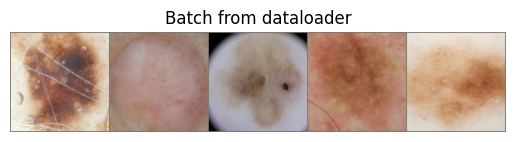

1 [('How is the global pattern?', 'How is the global pattern?', 'How is the global pattern?', 'How is the global pattern?', 'How is the global pattern?'), ('Can you describe the overall pattern?', 'Can you describe the overall pattern?', 'Can you describe the overall pattern?', 'Can you describe the overall pattern?', 'Can you describe the overall pattern?'), ('Describe the pattern observed globally.', 'Describe the pattern observed globally.', 'Describe the pattern observed globally.', 'Describe the pattern observed globally.', 'Describe the pattern observed globally.'), ('What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?'), ('What patterns are present in the entire lesion?', 'What patterns are present in the entire lesion?', 'What patterns are present in the entire lesion?', 'What patt

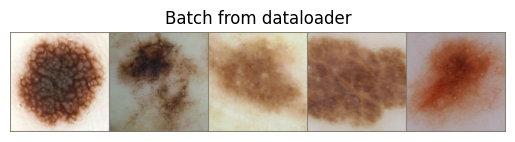

In [110]:
# Iterate over the dataloader and visualize batches
for i_batch, sample_batched in enumerate(train_isic_dataloader):
    print(i_batch, sample_batched[2])
    show_batch(sample_batched)

    # Show only the data of the 3rd batch and stop.
    if i_batch == 1:
        break

## Image Feature Extraction

In [111]:
def extract_image_features(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    num_samples = len(dataloader.dataset)

    output_shape = (7,7,512) # Keep dimensionality of outputs (layer 4)

    # Calculate the total number of features
    num_features = np.prod(output_shape)

    features = np.zeros((num_samples, *output_shape), dtype=np.float32)
    sample_idx = 0

    with torch.no_grad():
        for sample in dataloader:
            # Get images
            inputs = sample[0].to(device).float()

            # Forward pass
            outputs = model(inputs)

            outputs_reshaped = outputs.reshape(outputs.size(0), *output_shape)

            # Store features
            batch_size = inputs.size(0)
            # features[sample_idx:sample_idx + batch_size, :] = outputs_flat.cpu().numpy()
            features[sample_idx:sample_idx + batch_size, :] = outputs_reshaped.cpu().numpy()
            sample_idx += batch_size

    return torch.tensor(features, device=device)

In [112]:
# Function to print GPU memory usage
def print_gpu_memory():
    print(f"Memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Memory reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

## VQA Model Creation

In [113]:
class VQAModel(nn.Module):
    def __init__(self, resnet, vlm, tokenizer):
        super(VQAModel, self).__init__()

        # Pre-trained ResNet model
        self.resnet = resnet
        # Vision Language Model
        self.vlm = vlm
        # Tokenizer
        self.tokenizer = tokenizer
        # Freeze parameters of the ResNet model
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, image_features, question, labels_idxs=None, training=False):

        # image_features -> array with visual features for the specific image (7x7x512)
        # question -> individual question within the image batch
        # labels_idx -> tensor with shape (0, ..., num_labels-1)
        # training; boolean to determine the mode (train/evaluation)

        # Prepare image inputs -> (batch_size, visual_seq_length, visual_embedding_dim)
        flattened_embedding = image_features.view(-1, 512) # (49x512)
        visual_embeds = flattened_embedding.unsqueeze(0) # (1x49x512)

        # Token type and attention masks -> (batch_size, visual_seq_length)
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long, device=device)
        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.float, device=device)

        # Tokenize question
        tokenized_question = self.tokenizer(question,
                                            return_token_type_ids=True,
                                            return_attention_mask=True,
                                            add_special_tokens=True,
                                            return_tensors='pt')

        # Input for the VLM model (refer to VisualBert to understand the shapes)
        input_dict = {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
            "input_ids": tokenized_question['input_ids'].to(device),
            "token_type_ids": tokenized_question['token_type_ids'].to(device),
            "attention_mask": tokenized_question['attention_mask'].to(device),
        }

        # Training mode: track gradients
        if training:

            output = self.vlm(**input_dict, labels=labels_idxs)
            logits = output.logits
            loss = output.loss
            attentions = output.attentions

            del output

        # Evaluation mode: no gradients
        else:
            with torch.no_grad():
                output = self.vlm(**input_dict, labels=labels_idxs)
                logits = output.logits
                loss = output.loss
                attentions = output.attentions

        # # Check for memory usage
        # print_gpu_memory()

        return logits, loss, attentions

### Define LLM & Tokenizer

In [114]:
# Pre-trained base case for VQA provided in documentation
# tokenizer = AutoTokenizer.from_pretrained("deepset/bert-base-cased-squad2")
# bertModel = BertForQuestionAnswering.from_pretrained("deepset/bert-base-cased-squad2")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
# Modify the visual embedding config so that size of the features matches
configuration = VisualBertConfig.from_pretrained("uclanlp/visualbert-vqa",
                                                 visual_embedding_dim=512,
                                                 num_labels=answers_ids_tensor.shape[0],
                                                 output_attentions=True)
visualBert = VisualBertForQuestionAnswering(configuration)

## Training Loop

In [115]:
# Create the VQA Model and pass it to the GPU
vqa_model = VQAModel(resnet, visualBert, tokenizer)

In [116]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vqa_model.to(device)

VQAModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [122]:
# Define hyperparameters
learning_rate = 5e-5
num_epochs = 10

In [123]:
# Define optimizer
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, vqa_model.parameters()), lr=learning_rate)

In [119]:
# Extract all image features for the dataloaders
with torch.no_grad():
    # Train
    image_features_isic = extract_image_features(vqa_model.resnet, train_isic_dataloader)
    image_features_pizarro = extract_image_features(vqa_model.resnet, train_pizarro_dataloader)
    # Test
    image_features_isic_test = extract_image_features(vqa_model.resnet, test_isic_dataloader)
    image_features_pizarro_test = extract_image_features(vqa_model.resnet, test_pizarro_dataloader)

In [120]:
# Train
image_features_dataloaders = [image_features_isic, image_features_pizarro]
dataloaders = [train_isic_dataloader, train_pizarro_dataloader]
# Test
image_features_dataloaders_test = [image_features_isic_test, image_features_pizarro_test]
dataloaders_test = [test_isic_dataloader, test_pizarro_dataloader]

### Backward pass per question

In [121]:
# def train(model, dataloaders, image_features_dataloaders, num_epochs, optimizer, id2label, label2id):

#     # Set the model in training mode
#     model.train()

#     # Loss function
#     lossCriteria = nn.CrossEntropyLoss()

#     # Start training
#     for epoch in range(num_epochs):
#         total_loss = 0.0
#         num_batches = 0

#         #text_results = []

#         # Train for each dataloader
#         for data_idx in range(len(dataloaders)):

#             # Select dataloader and image features
#             dataloader = dataloaders[data_idx]
#             image_features = image_features_dataloaders[data_idx]

#             print(f'Dataset number: {data_idx + 1}')
#             print()

#             for images, masks, questions, answers in tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):

#                 # Track batch loss
#                 batch_loss = 0.0

#                 # Transpose questions and answers
#                 questions = np.transpose(questions)
#                 answers = np.transpose(answers)
#                 # Store shape for iteration
#                 num_images, num_questions_per_image = np.shape(questions)

#                 # Iterate over all questions for each image
#                 for image_idx in range(num_images):
#                   for question_idx in range(num_questions_per_image):

#                     # Avoid using previous gradients
#                     optimizer.zero_grad()

#                     #Forward pass
#                     outputs, _, _ = model(image_features[image_idx], questions[image_idx,question_idx], answers_ids_tensor, training=True)

#                     # Prediction + Ground truth (ID)
#                     #outputs = outputs.unsqueeze(0)
#                     target_index = label2id[answers[image_idx, question_idx]]
#                     target = torch.tensor([target_index], device=device)

#                     # Compute classification loss
#                     loss = lossCriteria(outputs, target)

#                     # Backpropagation
#                     loss.backward()
#                     optimizer.step()

#                     batch_loss += loss.item() / (num_images * num_questions_per_image)

#                     # Remove unnecessary tensors from memory
#                     del loss

#                 # Print batch loss
#                 print(f"Batch Loss: {batch_loss}")

#                 # Accumulate the total loss and num of batches
#                 total_loss += batch_loss
#                 num_batches += 1

#         # Average training loss for the epoch
#         avg_loss = total_loss / num_batches
#         print(f"Epoch {epoch + 1}, Average Loss: {avg_loss}")

#         # Save trained model after each epoch
#         torch.save(vqa_model.state_dict(), os.path.join('/content/drive/MyDrive/TFG Juan Villanueva/', f'trained_vqa_model2_crossEntropy_epoch{epoch+1}.pth'))

### Backward pass per image (all questions)

In [124]:
def train(model, dataloaders, dataloaders_test, image_features_dataloaders, image_features_dataloaders_test, num_epochs, optimizer, id2label, label2id):

    # Set the model in training mode
    model.train()

    # Loss function
    lossCriteria = nn.CrossEntropyLoss()

    # Epochs loss
    train_epoch_losses = []
    test_epoch_losses = []

    # Start training
    for epoch in range(num_epochs):
        total_loss = 0.0
        num_batches = 0

        # Train for each dataloader
        for data_idx in range(len(dataloaders)):

            # Select dataloader and image features
            dataloader = dataloaders[data_idx]
            image_features = image_features_dataloaders[data_idx]

            print(f'Dataset number: {data_idx + 1}')
            print()

            for images, masks, questions, answers in tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):

                # Track batch loss
                batch_loss = 0.0

                # Transpose questions and answers
                questions = np.transpose(questions)
                answers = np.transpose(answers)
                # Store shape for iteration
                num_images, num_questions_per_image = np.shape(questions)

                # Iterate over all questions for each image
                for image_idx in range(num_images):

                  # Avoid using previous gradients
                  optimizer.zero_grad()

                  # Store questions loss
                  image_losses = []

                  for question_idx in range(num_questions_per_image):

                    #Forward pass
                    outputs, _, _ = model(image_features[image_idx], questions[image_idx,question_idx], answers_ids_tensor, training=True)

                    # Prediction + Ground truth (ID)
                    target_index = label2id[answers[image_idx, question_idx]]
                    target = torch.tensor([target_index], device=device)

                    # Compute classification loss for the question and store it
                    loss = lossCriteria(outputs, target)
                    image_losses.append(loss)


                  # Aggregate losses for all questions within the same image
                  total_image_loss = torch.stack(image_losses).sum() / num_questions_per_image

                  # Add to batch loss
                  batch_loss += total_image_loss.item() / num_images

                  # Backpropagation
                  total_image_loss.backward()
                  optimizer.step()

                  del total_image_loss, image_losses

                # Print batch loss
                print(f"Batch Loss: {batch_loss}")

                # Accumulate the total loss and num of batches
                total_loss += batch_loss
                num_batches += 1

        # Average training loss for the epoch
        avg_loss = total_loss / num_batches
        train_epoch_losses.append(avg_loss)

        # Average test loss for the epoch
        _, avg_test_loss = test(model, dataloaders_test, image_features_dataloaders_test, id2label, label2id)
        test_epoch_losses.append(avg_loss)

        print(f"Epoch {epoch + 1}, Average Training Loss: {avg_loss}")
        print(f"Epoch {epoch + 1}, Average Testing Loss: {avg_test_loss}")

        # Save trained model after each epoch
        torch.save(vqa_model.state_dict(), os.path.join('/content/drive/MyDrive/TFG Juan Villanueva/', f'trained_vqa_model4_imageLoss_epoch{epoch+1}.pth'))

    return train_epoch_losses, test_epoch_losses

### Test function (no gradients)

In [125]:
def test(model, dataloaders, image_features_dataloaders, id2label, label2id):
    # Set the model in evaluation mode
    model.eval()

    # List to store results (by dataset)
    results = [[] for _ in range(len(dataloaders))]

    lossCriteria = nn.CrossEntropyLoss()

    total_loss = 0.0
    num_batches = 0

    # Iterate over datasets
    for data_idx in range(len(dataloaders)):
        dataloader = dataloaders[data_idx]
        image_features = image_features_dataloaders[data_idx]

        print(f'Testing dataset number: {data_idx + 1}\n')

        for images, masks, questions, answers in tqdm(dataloader, desc=f'Testing dataset {data_idx + 1}', unit='batch'):

            batch_results = []
            batch_idx = 0
            batch_loss = 0.0

            # Transpose questions and answers
            questions = np.transpose(questions)
            answers = np.transpose(answers)

            num_images, num_questions_per_image = np.shape(questions)

            # Iterate over all questions for each image
            for image_idx in range(num_images):

                total_image_loss = 0.0

                for question_idx in range(num_questions_per_image):

                    # Forward pass
                    with torch.no_grad():
                        outputs, _, _ = model(image_features[image_idx], questions[image_idx, question_idx], answers_ids_tensor, training=False)

                    # Get predicted label
                    probabilities = torch.softmax(outputs, dim=-1)
                    pred_idx = torch.argmax(probabilities, dim=-1)
                    pred_label = id2label[pred_idx.item()]

                    # Get ground truth label
                    true_label = answers[image_idx, question_idx]
                    target_index = label2id[true_label]
                    target = torch.tensor([target_index], device=device)

                    # Compute loss and store it
                    loss = lossCriteria(outputs, target)

                    # Add to average image loss
                    total_image_loss = loss.item() / num_questions_per_image

                    del loss

                    # # Convert attention tensors to lists
                    # attentions_list = [layer.tolist() for layer in attentions]

                    # Store results
                    batch_results.append({
                        "Batch ID": batch_idx,
                        "Image ID": image_idx,
                        "Question": questions[image_idx, question_idx],
                        "Ground Truth": true_label,
                        "Prediction": pred_label
                        #"Attention": attentions_list  # 12x1x12x57x57 (Layer x Num Obs. x Attention Head x Input Features x Input Features)
                    })

                batch_loss += total_image_loss / num_images

            # Loss contribution of the batch for the total loss
            total_loss += batch_loss
            num_batches +=1

            # Store batch results
            results[data_idx].append(batch_results)

            # Increment batch index
            batch_idx += 1

    avg_loss = total_loss / num_batches

    return results, avg_loss

### Initialize training

In [126]:
train_epoch_losses, test_epoch_losses = train(vqa_model, dataloaders, dataloaders_test, image_features_dataloaders, image_features_dataloaders_test, num_epochs, optimizer, id2label, label2id)

Dataset number: 1



Epoch 1/10:   1%|▏         | 1/71 [00:12<14:13, 12.19s/batch]

Batch Loss: 4.016379404067993


Epoch 1/10:   3%|▎         | 2/71 [00:23<13:34, 11.80s/batch]

Batch Loss: 3.114601564407349


Epoch 1/10:   4%|▍         | 3/71 [00:35<13:06, 11.57s/batch]

Batch Loss: 3.5985214710235596


Epoch 1/10:   6%|▌         | 4/71 [00:46<12:46, 11.43s/batch]

Batch Loss: 2.7909838199615478


Epoch 1/10:   7%|▋         | 5/71 [00:57<12:33, 11.42s/batch]

Batch Loss: 2.96421422958374


Epoch 1/10:   8%|▊         | 6/71 [01:09<12:23, 11.44s/batch]

Batch Loss: 2.5999428749084474


Epoch 1/10:  10%|▉         | 7/71 [01:20<12:07, 11.37s/batch]

Batch Loss: 2.9623408317565914


Epoch 1/10:  11%|█▏        | 8/71 [01:31<11:57, 11.39s/batch]

Batch Loss: 2.931471824645996


Epoch 1/10:  13%|█▎        | 9/71 [01:42<11:40, 11.30s/batch]

Batch Loss: 2.572978830337525


Epoch 1/10:  14%|█▍        | 10/71 [01:54<11:31, 11.33s/batch]

Batch Loss: 2.7637157917022703


Epoch 1/10:  15%|█▌        | 11/71 [02:05<11:23, 11.38s/batch]

Batch Loss: 2.0970492362976074


Epoch 1/10:  17%|█▋        | 12/71 [02:16<11:08, 11.33s/batch]

Batch Loss: 1.9341909170150755


Epoch 1/10:  18%|█▊        | 13/71 [02:28<10:58, 11.36s/batch]

Batch Loss: 1.8401306390762329


Epoch 1/10:  20%|█▉        | 14/71 [02:39<10:47, 11.37s/batch]

Batch Loss: 1.0751204371452332


Epoch 1/10:  21%|██        | 15/71 [02:51<10:36, 11.37s/batch]

Batch Loss: 1.1028694748878478


Epoch 1/10:  23%|██▎       | 16/71 [03:02<10:19, 11.27s/batch]

Batch Loss: 1.1368710517883303


Epoch 1/10:  24%|██▍       | 17/71 [03:13<10:11, 11.32s/batch]

Batch Loss: 0.5884387850761414


Epoch 1/10:  25%|██▌       | 18/71 [03:25<10:07, 11.47s/batch]

Batch Loss: 1.053678819537163


Epoch 1/10:  27%|██▋       | 19/71 [03:36<09:54, 11.44s/batch]

Batch Loss: 1.002991446852684


Epoch 1/10:  28%|██▊       | 20/71 [03:48<09:46, 11.51s/batch]

Batch Loss: 0.9148560523986817


Epoch 1/10:  30%|██▉       | 21/71 [04:00<09:35, 11.52s/batch]

Batch Loss: 1.1107482075691224


Epoch 1/10:  31%|███       | 22/71 [04:11<09:23, 11.50s/batch]

Batch Loss: 0.5367603987455368


Epoch 1/10:  32%|███▏      | 23/71 [04:23<09:14, 11.54s/batch]

Batch Loss: 0.6955712735652924


Epoch 1/10:  34%|███▍      | 24/71 [04:34<08:59, 11.48s/batch]

Batch Loss: 0.5982584804296494


Epoch 1/10:  35%|███▌      | 25/71 [04:46<08:51, 11.55s/batch]

Batch Loss: 0.5110134899616241


Epoch 1/10:  37%|███▋      | 26/71 [04:57<08:37, 11.51s/batch]

Batch Loss: 1.5070572555065154


Epoch 1/10:  38%|███▊      | 27/71 [05:08<08:22, 11.42s/batch]

Batch Loss: 0.7641756147146226


Epoch 1/10:  39%|███▉      | 28/71 [05:20<08:18, 11.58s/batch]

Batch Loss: 0.512497627735138


Epoch 1/10:  41%|████      | 29/71 [05:32<08:10, 11.67s/batch]

Batch Loss: 1.079126089811325


Epoch 1/10:  42%|████▏     | 30/71 [05:44<07:56, 11.62s/batch]

Batch Loss: 0.6224696695804597


Epoch 1/10:  44%|████▎     | 31/71 [05:55<07:40, 11.51s/batch]

Batch Loss: 0.8597155570983886


Epoch 1/10:  45%|████▌     | 32/71 [06:06<07:27, 11.47s/batch]

Batch Loss: 1.0693739295005797


Epoch 1/10:  46%|████▋     | 33/71 [06:18<07:24, 11.69s/batch]

Batch Loss: 0.6937209784984588


Epoch 1/10:  48%|████▊     | 34/71 [06:29<07:05, 11.49s/batch]

Batch Loss: 0.6053042113780975


Epoch 1/10:  49%|████▉     | 35/71 [06:41<06:51, 11.44s/batch]

Batch Loss: 0.5780032694339752


Epoch 1/10:  51%|█████     | 36/71 [06:52<06:41, 11.48s/batch]

Batch Loss: 0.8257212698459625


Epoch 1/10:  52%|█████▏    | 37/71 [07:04<06:28, 11.42s/batch]

Batch Loss: 0.6523428201675415


Epoch 1/10:  54%|█████▎    | 38/71 [07:16<06:23, 11.62s/batch]

Batch Loss: 1.1420748829841616


Epoch 1/10:  55%|█████▍    | 39/71 [07:27<06:11, 11.62s/batch]

Batch Loss: 0.748814618587494


Epoch 1/10:  56%|█████▋    | 40/71 [07:39<05:59, 11.59s/batch]

Batch Loss: 0.7068833827972412


Epoch 1/10:  58%|█████▊    | 41/71 [07:50<05:45, 11.53s/batch]

Batch Loss: 0.6130204796791077


Epoch 1/10:  59%|█████▉    | 42/71 [08:01<05:31, 11.43s/batch]

Batch Loss: 0.32897814810276027


Epoch 1/10:  61%|██████    | 43/71 [08:14<05:32, 11.86s/batch]

Batch Loss: 0.9221511587500572


Epoch 1/10:  62%|██████▏   | 44/71 [08:25<05:14, 11.63s/batch]

Batch Loss: 0.6111936241388322


Epoch 1/10:  63%|██████▎   | 45/71 [08:37<04:58, 11.46s/batch]

Batch Loss: 0.9438521206378937


Epoch 1/10:  65%|██████▍   | 46/71 [08:48<04:44, 11.37s/batch]

Batch Loss: 1.0815544217824937


Epoch 1/10:  66%|██████▌   | 47/71 [09:00<04:36, 11.53s/batch]

Batch Loss: 0.7818594098091125


Epoch 1/10:  68%|██████▊   | 48/71 [09:11<04:21, 11.38s/batch]

Batch Loss: 0.5928644418716431


Epoch 1/10:  69%|██████▉   | 49/71 [09:24<04:25, 12.08s/batch]

Batch Loss: 1.5044650793075562


Epoch 1/10:  70%|███████   | 50/71 [09:36<04:09, 11.86s/batch]

Batch Loss: 0.6884155750274659


Epoch 1/10:  72%|███████▏  | 51/71 [09:47<03:56, 11.80s/batch]

Batch Loss: 0.8088765501976013


Epoch 1/10:  73%|███████▎  | 52/71 [09:58<03:39, 11.58s/batch]

Batch Loss: 0.5330000221729279


Epoch 1/10:  75%|███████▍  | 53/71 [10:10<03:25, 11.44s/batch]

Batch Loss: 0.6713566839694975


Epoch 1/10:  76%|███████▌  | 54/71 [10:21<03:13, 11.40s/batch]

Batch Loss: 0.8264229595661163


Epoch 1/10:  77%|███████▋  | 55/71 [10:33<03:04, 11.55s/batch]

Batch Loss: 0.7241039246320724


Epoch 1/10:  79%|███████▉  | 56/71 [10:44<02:53, 11.59s/batch]

Batch Loss: 0.6805762439966202


Epoch 1/10:  80%|████████  | 57/71 [10:56<02:42, 11.64s/batch]

Batch Loss: 0.8264212906360626


Epoch 1/10:  82%|████████▏ | 58/71 [11:07<02:29, 11.48s/batch]

Batch Loss: 0.5007469534873963


Epoch 1/10:  83%|████████▎ | 59/71 [11:19<02:18, 11.57s/batch]

Batch Loss: 0.23278760612010957


Epoch 1/10:  85%|████████▍ | 60/71 [11:31<02:07, 11.57s/batch]

Batch Loss: 0.5350071832537652


Epoch 1/10:  86%|████████▌ | 61/71 [11:42<01:55, 11.58s/batch]

Batch Loss: 1.0087695211172103


Epoch 1/10:  87%|████████▋ | 62/71 [11:53<01:42, 11.44s/batch]

Batch Loss: 0.9601404190063476


Epoch 1/10:  89%|████████▊ | 63/71 [12:06<01:33, 11.74s/batch]

Batch Loss: 0.6962403655052185


Epoch 1/10:  90%|█████████ | 64/71 [12:17<01:21, 11.57s/batch]

Batch Loss: 0.6897661447525023


Epoch 1/10:  92%|█████████▏| 65/71 [12:28<01:08, 11.46s/batch]

Batch Loss: 1.0624538838863373


Epoch 1/10:  93%|█████████▎| 66/71 [12:39<00:56, 11.39s/batch]

Batch Loss: 0.2944710522890091


Epoch 1/10:  94%|█████████▍| 67/71 [12:51<00:45, 11.40s/batch]

Batch Loss: 0.8107213437557221


Epoch 1/10:  96%|█████████▌| 68/71 [13:02<00:34, 11.42s/batch]

Batch Loss: 0.46219310760498045


Epoch 1/10:  97%|█████████▋| 69/71 [13:13<00:22, 11.34s/batch]

Batch Loss: 0.44484715461730956


Epoch 1/10:  99%|█████████▊| 70/71 [13:25<00:11, 11.35s/batch]

Batch Loss: 0.7187205344438552


Epoch 1/10: 100%|██████████| 71/71 [13:30<00:00, 11.42s/batch]


Batch Loss: 0.9003413617610931
Dataset number: 2



Epoch 1/10:   1%|▏         | 1/80 [00:16<21:29, 16.32s/batch]

Batch Loss: 3.1065566062927243


Epoch 1/10:   2%|▎         | 2/80 [00:32<20:56, 16.11s/batch]

Batch Loss: 2.4266872644424438


Epoch 1/10:   4%|▍         | 3/80 [00:48<20:33, 16.01s/batch]

Batch Loss: 2.2535639286041262


Epoch 1/10:   5%|▌         | 4/80 [01:04<20:16, 16.01s/batch]

Batch Loss: 1.8496899127960207


Epoch 1/10:   6%|▋         | 5/80 [01:20<20:03, 16.05s/batch]

Batch Loss: 1.6632080793380737


Epoch 1/10:   8%|▊         | 6/80 [01:36<19:44, 16.01s/batch]

Batch Loss: 1.774686050415039


Epoch 1/10:   9%|▉         | 7/80 [01:52<19:27, 16.00s/batch]

Batch Loss: 1.4003971099853516


Epoch 1/10:  10%|█         | 8/80 [02:08<19:15, 16.05s/batch]

Batch Loss: 1.2996277570724488


Epoch 1/10:  11%|█▏        | 9/80 [02:24<18:57, 16.02s/batch]

Batch Loss: 1.2197293996810914


Epoch 1/10:  12%|█▎        | 10/80 [02:40<18:43, 16.05s/batch]

Batch Loss: 1.4976332306861877


Epoch 1/10:  14%|█▍        | 11/80 [02:56<18:23, 16.00s/batch]

Batch Loss: 1.2451300501823426


Epoch 1/10:  15%|█▌        | 12/80 [03:12<18:08, 16.01s/batch]

Batch Loss: 1.465210771560669


Epoch 1/10:  16%|█▋        | 13/80 [03:28<17:54, 16.04s/batch]

Batch Loss: 1.2422892570495605


Epoch 1/10:  18%|█▊        | 14/80 [03:44<17:36, 16.01s/batch]

Batch Loss: 1.1038187742233276


Epoch 1/10:  19%|█▉        | 15/80 [04:00<17:20, 16.00s/batch]

Batch Loss: 1.0668129324913025


Epoch 1/10:  20%|██        | 16/80 [04:16<17:01, 15.97s/batch]

Batch Loss: 0.9887146115303039


Epoch 1/10:  21%|██▏       | 17/80 [04:32<16:49, 16.02s/batch]

Batch Loss: 1.5178917169570922


Epoch 1/10:  22%|██▎       | 18/80 [04:48<16:30, 15.98s/batch]

Batch Loss: 0.9939677000045777


Epoch 1/10:  24%|██▍       | 19/80 [05:04<16:13, 15.97s/batch]

Batch Loss: 1.1940717101097107


Epoch 1/10:  25%|██▌       | 20/80 [05:20<16:02, 16.04s/batch]

Batch Loss: 1.1289926052093506


Epoch 1/10:  26%|██▋       | 21/80 [05:36<15:46, 16.04s/batch]

Batch Loss: 1.255887472629547


Epoch 1/10:  28%|██▊       | 22/80 [05:52<15:28, 16.00s/batch]

Batch Loss: 1.3827789902687073


Epoch 1/10:  29%|██▉       | 23/80 [06:08<15:10, 15.97s/batch]

Batch Loss: 1.2703861713409423


Epoch 1/10:  30%|███       | 24/80 [06:24<14:57, 16.03s/batch]

Batch Loss: 1.0828525066375732


Epoch 1/10:  31%|███▏      | 25/80 [06:40<14:39, 15.98s/batch]

Batch Loss: 1.1849806666374207


Epoch 1/10:  32%|███▎      | 26/80 [06:56<14:22, 15.97s/batch]

Batch Loss: 1.162030780315399


Epoch 1/10:  34%|███▍      | 27/80 [07:12<14:10, 16.05s/batch]

Batch Loss: 1.0592631220817565


Epoch 1/10:  35%|███▌      | 28/80 [07:28<13:51, 16.00s/batch]

Batch Loss: 1.2257436394691466


Epoch 1/10:  36%|███▋      | 29/80 [07:44<13:37, 16.03s/batch]

Batch Loss: 0.937338125705719


Epoch 1/10:  38%|███▊      | 30/80 [08:00<13:19, 15.99s/batch]

Batch Loss: 1.03043212890625


Epoch 1/10:  39%|███▉      | 31/80 [08:16<13:02, 15.98s/batch]

Batch Loss: 0.8143750488758087


Epoch 1/10:  40%|████      | 32/80 [08:32<12:49, 16.03s/batch]

Batch Loss: 1.2570507407188416


Epoch 1/10:  41%|████▏     | 33/80 [08:48<12:31, 16.00s/batch]

Batch Loss: 1.2863879323005676


Epoch 1/10:  42%|████▎     | 34/80 [09:04<12:14, 15.97s/batch]

Batch Loss: 1.1551665186882019


Epoch 1/10:  44%|████▍     | 35/80 [09:20<11:58, 15.97s/batch]

Batch Loss: 1.0274625301361084


Epoch 1/10:  45%|████▌     | 36/80 [09:36<11:43, 15.99s/batch]

Batch Loss: 1.0161900997161866


Epoch 1/10:  46%|████▋     | 37/80 [09:52<11:26, 15.95s/batch]

Batch Loss: 1.171470081806183


Epoch 1/10:  48%|████▊     | 38/80 [10:08<11:10, 15.96s/batch]

Batch Loss: 1.0880890011787414


Epoch 1/10:  49%|████▉     | 39/80 [10:24<10:57, 16.04s/batch]

Batch Loss: 1.079844605922699


Epoch 1/10:  50%|█████     | 40/80 [10:40<10:39, 15.99s/batch]

Batch Loss: 1.0118857741355896


Epoch 1/10:  51%|█████▏    | 41/80 [10:56<10:22, 15.97s/batch]

Batch Loss: 0.9383363127708434


Epoch 1/10:  52%|█████▎    | 42/80 [11:12<10:05, 15.94s/batch]

Batch Loss: 1.1274107933044435


Epoch 1/10:  54%|█████▍    | 43/80 [11:28<09:51, 15.99s/batch]

Batch Loss: 0.9840528607368471


Epoch 1/10:  55%|█████▌    | 44/80 [11:44<09:34, 15.97s/batch]

Batch Loss: 1.374187922477722


Epoch 1/10:  56%|█████▋    | 45/80 [12:00<09:17, 15.94s/batch]

Batch Loss: 1.0252033829689027


Epoch 1/10:  57%|█████▊    | 46/80 [12:16<09:04, 16.01s/batch]

Batch Loss: 1.0064186096191405


Epoch 1/10:  59%|█████▉    | 47/80 [12:32<08:48, 16.00s/batch]

Batch Loss: 1.0552632927894592


Epoch 1/10:  60%|██████    | 48/80 [12:48<08:32, 16.02s/batch]

Batch Loss: 1.0006125450134276


Epoch 1/10:  61%|██████▏   | 49/80 [13:04<08:16, 16.02s/batch]

Batch Loss: 0.7946168541908265


Epoch 1/10:  62%|██████▎   | 50/80 [13:20<08:00, 16.03s/batch]

Batch Loss: 0.9972732424736024


Epoch 1/10:  64%|██████▍   | 51/80 [13:36<07:45, 16.05s/batch]

Batch Loss: 1.4885462403297425


Epoch 1/10:  65%|██████▌   | 52/80 [13:52<07:27, 15.99s/batch]

Batch Loss: 1.0280983924865723


Epoch 1/10:  66%|██████▋   | 53/80 [14:08<07:10, 15.96s/batch]

Batch Loss: 1.1506468415260316


Epoch 1/10:  68%|██████▊   | 54/80 [14:24<06:54, 15.94s/batch]

Batch Loss: 1.268922472000122


Epoch 1/10:  69%|██████▉   | 55/80 [14:40<06:39, 16.00s/batch]

Batch Loss: 1.197312581539154


Epoch 1/10:  70%|███████   | 56/80 [14:56<06:23, 15.97s/batch]

Batch Loss: 1.2509762644767761


Epoch 1/10:  71%|███████▏  | 57/80 [15:11<06:06, 15.95s/batch]

Batch Loss: 1.3101449489593504


Epoch 1/10:  72%|███████▎  | 58/80 [15:28<05:52, 16.02s/batch]

Batch Loss: 1.2005982398986816


Epoch 1/10:  74%|███████▍  | 59/80 [15:44<05:36, 16.01s/batch]

Batch Loss: 1.1744150638580322


Epoch 1/10:  75%|███████▌  | 60/80 [16:00<05:19, 15.98s/batch]

Batch Loss: 1.1013837933540342


Epoch 1/10:  76%|███████▋  | 61/80 [16:16<05:03, 15.99s/batch]

Batch Loss: 1.131707799434662


Epoch 1/10:  78%|███████▊  | 62/80 [16:32<04:48, 16.02s/batch]

Batch Loss: 1.1525726437568664


Epoch 1/10:  79%|███████▉  | 63/80 [16:48<04:31, 15.99s/batch]

Batch Loss: 0.9905925035476685


Epoch 1/10:  80%|████████  | 64/80 [17:04<04:15, 15.97s/batch]

Batch Loss: 1.1181128859519958


Epoch 1/10:  81%|████████▏ | 65/80 [17:20<04:00, 16.03s/batch]

Batch Loss: 1.0397727847099305


Epoch 1/10:  82%|████████▎ | 66/80 [17:36<03:44, 16.03s/batch]

Batch Loss: 1.0458255767822267


Epoch 1/10:  84%|████████▍ | 67/80 [17:52<03:28, 16.05s/batch]

Batch Loss: 1.2229138374328614


Epoch 1/10:  85%|████████▌ | 68/80 [18:08<03:12, 16.01s/batch]

Batch Loss: 1.0802430272102357


Epoch 1/10:  86%|████████▋ | 69/80 [18:24<02:56, 16.00s/batch]

Batch Loss: 0.9573057174682618


Epoch 1/10:  88%|████████▊ | 70/80 [18:40<02:40, 16.08s/batch]

Batch Loss: 0.888789975643158


Epoch 1/10:  89%|████████▉ | 71/80 [18:56<02:24, 16.04s/batch]

Batch Loss: 1.03571218252182


Epoch 1/10:  90%|█████████ | 72/80 [19:12<02:08, 16.02s/batch]

Batch Loss: 0.7698980450630187


Epoch 1/10:  91%|█████████▏| 73/80 [19:28<01:52, 16.04s/batch]

Batch Loss: 1.0493695616722107


Epoch 1/10:  92%|█████████▎| 74/80 [19:44<01:36, 16.09s/batch]

Batch Loss: 1.2388948440551757


Epoch 1/10:  94%|█████████▍| 75/80 [20:00<01:20, 16.08s/batch]

Batch Loss: 1.1998551845550538


Epoch 1/10:  95%|█████████▌| 76/80 [20:16<01:04, 16.07s/batch]

Batch Loss: 0.9940170764923096


Epoch 1/10:  96%|█████████▋| 77/80 [20:33<00:48, 16.12s/batch]

Batch Loss: 1.278971564769745


Epoch 1/10:  98%|█████████▊| 78/80 [20:49<00:32, 16.11s/batch]

Batch Loss: 1.0820651173591613


Epoch 1/10:  99%|█████████▉| 79/80 [21:05<00:16, 16.05s/batch]

Batch Loss: 0.9108723163604736


Epoch 1/10: 100%|██████████| 80/80 [21:21<00:00, 16.02s/batch]


Batch Loss: 1.0778526663780212
Epoch 1, Average Training Loss: 1.1789096733000104
Testing dataset number: 1



Testing dataset 1: 100%|██████████| 18/18 [01:16<00:00,  4.27s/batch]


Testing dataset number: 2



Testing dataset 2: 100%|██████████| 20/20 [01:53<00:00,  5.65s/batch]


Epoch 1, Average Testing Loss: 1.1789096733000104
Dataset number: 1



Epoch 2/10:   1%|▏         | 1/71 [00:11<13:06, 11.24s/batch]

Batch Loss: 1.116493320465088


Epoch 2/10:   3%|▎         | 2/71 [00:22<12:48, 11.14s/batch]

Batch Loss: 0.5658853232860566


Epoch 2/10:   3%|▎         | 2/71 [00:32<18:26, 16.03s/batch]


KeyboardInterrupt: 

## Testing - Metrics

In [52]:
# Define a model instance
trainedVQAmodel = VQAModel(resnet, visualBert, tokenizer)
# Load trained model from Google Drive
model_path = '/content/drive/MyDrive/TFG Juan Villanueva/trained_vqa_model3_imageLoss_epoch10.pth'
try:
    state_dict = torch.load(model_path, map_location=device)
    # Assign the loaded state dictionary to the model
    trainedVQAmodel.load_state_dict(state_dict)
    print("Model loaded successfully!")
except FileNotFoundError:
    print(f"File not found at path: {model_path}")
except Exception as e:
    print(f"Error loading model: {e}")

Model loaded successfully!


In [ ]:
outputs, avg_test_loss = test(trainedVQAmodel, dataloaders_test, image_features_dataloaders_test, id2label, label2id)

In [ ]:
outputs[1][1]

In [ ]:
# attentions[0].size()

In [ ]:
# inputs = tokenizer.encode(questions[image_idx,question_idx],
#                           return_token_type_ids=True,
#                           return_tensors='pt')
# inputs

In [ ]:
# tokens = tokenizer.convert_ids_to_tokens(inputs[0])
# tokens

In [ ]:
# # Tokenize image features
# tokenized_features = []
# for i in range(7):
#     for j in range(7):
#         # Convert indices to token format
#         token = f'Feature {i+1}x{j+1}'
#         tokenized_features.append(token)

In [ ]:
# tokens_concatenated = tokens + tokenized_features
# len(tokens_concatenated)

58

In [ ]:
# tokens_concatenated

In [ ]:
# head_view(attentions, tokens_concatenated)

In [ ]:
# # Reshape attentions tensor to [12, 58, 58] to iterate over each attention head
# attentions = attentions[0].squeeze(0)

# # Plot heatmap for each attention head
# for head_index in range(attentions.size(0)):
#     # Get attention values for the current head
#     attention_values = attentions[head_index].cpu().numpy()

#     # Plot heatmap
#     plt.figure(figsize=(8, 6))
#     plt.imshow(attention_values, cmap='viridis', interpolation='nearest')
#     plt.colorbar()
#     plt.title(f'Attention Heatmap - Head {head_index + 1}')
#     plt.xlabel('Tokens')
#     plt.ylabel('Tokens')
#     plt.show()

In [ ]:
# # Extract attention values between sentence tokens and image feature placeholders
# token_attentions = attentions[:, :, :9, 9:]

# # Plot heatmap for each attention head
# num_heads = token_attentions.size(1)
# plt.figure(figsize=(15, 10))
# for head_index in range(num_heads):
#     plt.subplot(3, 4, head_index + 1)
#     sns.heatmap(token_attentions[0, head_index].T.cpu().numpy(), cmap='viridis', annot=True,
#                 xticklabels=tokens,
#                 yticklabels= tokenized_features)
#     plt.title(f'Attention Head {head_index + 1}')
#     plt.xlabel('Sentence Tokens')
#     plt.ylabel('Image Features')
# plt.tight_layout()
# plt.show()

In [ ]:
# predictions = []
# for image_idx in range(len(outputs)):
#   image_answers = []
#   for output in outputs[image_idx]:
#       logits = output.logits
#       probabilities = torch.softmax(logits, dim=-1)  # Apply softmax along the last dimension
#       pred_index = torch.argmax(probabilities, dim=-1)  # Get the index of the maximum probability
#       pred_label = id2label[pred_index.item()]
#       image_answers.append(pred_label)
#   predictions.append(image_answers)
# predictions